In [1]:
from pathlib import Path
import geopandas as gpd
import pandas as pd

from shapely.geometry import Polygon, Point, box
import re
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

%cd ..

c:\Users\javie\Documents\magister\propagacion-incendios


C:\Users\javie\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
carpeta = "data/procesado/satellite_data/suomi"
archivos = [f.name for f in Path(carpeta).iterdir() if f.is_file()]
regex = re.compile(r"A\d{7}\.\d{4}\.\d{3}") 

In [4]:
path_areas = Path('data/procesado/zonas_incendios/areas_buffer.geojson')
areas = gpd.read_file(path_areas)

### functions

In [3]:
import numpy as np
from shapely.affinity import rotate, translate
import pyproj

In [5]:
def extraer_fecha(cadena):
    año = int(cadena[1:5])
    dia_juliano = int(cadena[5:8])
    hora = int(cadena[9:11])
    minuto = int(cadena[11:13])
    
    fecha = datetime(año, 1, 1) + timedelta(days=dia_juliano - 1)
    fecha = fecha.replace(hour=hora, minute=minuto)
    return fecha

def make_pixel_square(point, size=375):
    half = size / 2
    return box(point.x - half, point.y - half, point.x + half, point.y + half)


def make_viirs_pixel(lat, lon, zenith_deg, azimuth_deg, size_nadir=375):
    """Crea pixel deformado segun angulo de observacion"""
    zenith_rad = np.deg2rad(zenith_deg)
    width = size_nadir / np.cos(zenith_rad)
    height = size_nadir

    # cuadrado centrado en (0,0)
    hw, hh = width / 2, height / 2
    rect = Polygon([(-hw, -hh), (-hw, hh), (hw, hh), (hw, -hh)])

    # rotar por azimuth
    pixel_rot = rotate(rect, -azimuth_deg, origin=(0, 0), use_radians=False)

    # proyectar punto a metros
    proj = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:5070", always_xy=True)
    x0, y0 = proj.transform(lon, lat)

    # trasladar al centroide
    pixel_proj = translate(pixel_rot, xoff=x0, yoff=y0)

    # a lat/lon
    back_proj = pyproj.Transformer.from_crs("EPSG:5070", "EPSG:4326", always_xy=True)
    return Polygon([back_proj.transform(x, y) for x, y in pixel_proj.exterior.coords])



### rev data

In [6]:
## path data
carpeta = "data/procesado/satellite_data/suomi"
archivos = [f.name for f in Path(carpeta).iterdir() if f.is_file()]
regex = re.compile(r"A\d{7}\.\d{4}\.\d{3}") 

In [7]:
satelite = 'suomi'
path_save = 'data/procesado/satellite_data/union'

gdf_zonas = gpd.read_file(path_save + f'/zonas_{satelite}.geojson')

In [8]:
gdf_zonas.I05_uncert_index.value_counts()

I05_uncert_index
1.0    30993
Name: count, dtype: int64

In [9]:
pix_invalidos = gdf_zonas[
    gdf_zonas['I04'].isna() |
    (gdf_zonas['I04_quality_flags'] != 0) |
    (gdf_zonas['quality_flag'] != 0)
]

In [10]:
pix_invalidos_aux = pix_invalidos[pix_invalidos.eval('zona == "bee_rock_creek"')]

In [11]:
gdf_zonas = gdf_zonas[gdf_zonas['I04_quality_flags'].isin([0, 4, 8])]

In [12]:
#gdf_zonas2 = gdf_zonas[gdf_zonas['I02_uncert_index'].isna()]
aux = gdf_zonas[gdf_zonas.eval('zona == "bee_rock_creek"')]

In [ ]:
aux['geometry'] = aux.apply(lambda row: make_viirs_pixel(row['latitude'],
                                                             row['longitude'],
                                                             row['sensor_zenith'],
                                                             row['sensor_azimuth']
                                                             ),
                                axis=1)

gdf_pixel_polys = gpd.GeoDataFrame(aux, geometry='geometry', crs='EPSG:4326')

c:\Users\javie\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
sum(gdf_pixel_polys.geometry.value_counts()>1)

0

### healphix

In [16]:
from rhealpixdggs.dggs import *
from shapely.geometry import Polygon

rdggs = RHEALPixDGGS()

In [17]:
geom = areas[areas['zona'] == 'bee_rock_creek']['geometry'].iloc[0]

nw = (geom.bounds[0], geom.bounds[3])
se = (geom.bounds[2], geom.bounds[1])
Nivel = 10

polygons = []
codigo = []
cells = rdggs.cells_from_region(Nivel, nw, se, plane=False)
for row in cells:
    for cell in row:
        coordenadas = []
        celda = str(cell)
        primero = [celda[0]]+ [int(c) for c in celda[1:]]
        c = rdggs.cell(primero)
        for d in c.boundary(n=2, plane=False):
            # coord = tuple(my_round(val, 14) for val in d)
            coord = tuple(round(val, 14) for val in d)            
            coordenadas.append(coord)
        if coordenadas[0] != coordenadas[-1]:
            coordenadas.append(coordenadas[0])
        codigo.append(celda)
        polygon = Polygon(coordenadas)
        polygons.append(polygon)

gdf_healpix = gpd.GeoDataFrame(crs="EPSG:4326", geometry=polygons)
gdf_healpix['Codigo'] = codigo

In [18]:
gdf_pixel_polys1 = gdf_pixel_polys[gdf_pixel_polys['date_time'] == '2025-04-15 07:24:00']
gdf_pixel_polys2 = gdf_pixel_polys[gdf_pixel_polys['date_time'] == '2025-04-15 18:42:00']

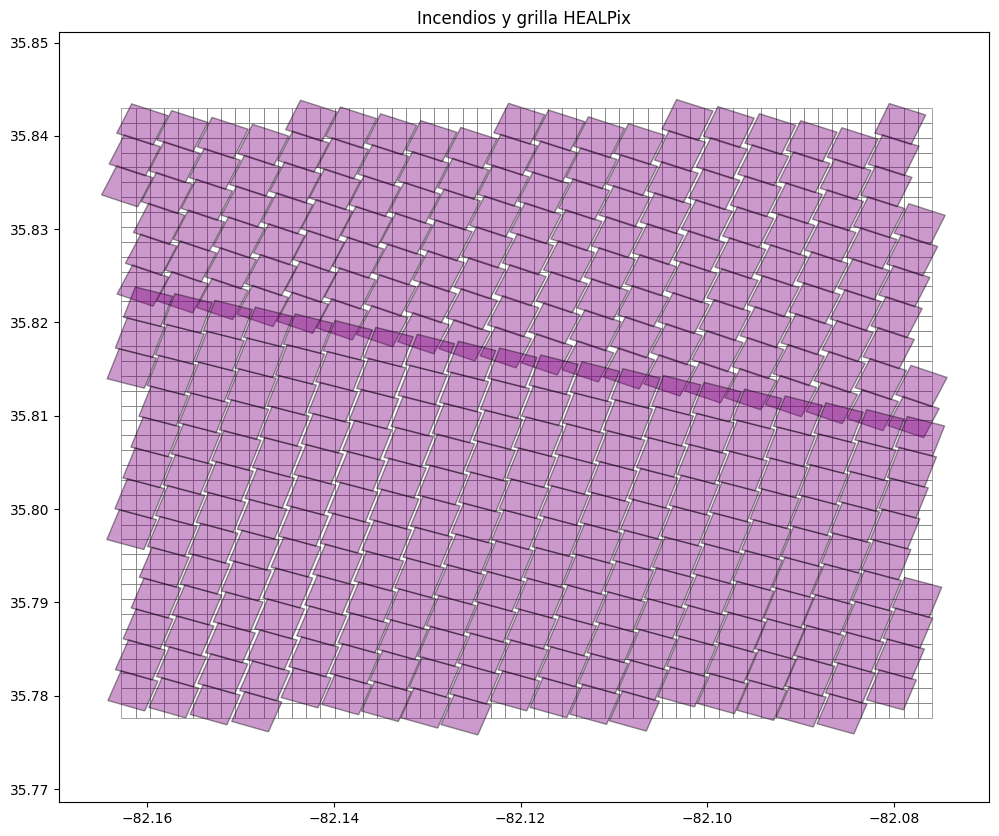

In [19]:
fig, ax = plt.subplots(figsize=(12, 10))

# grilla de fondo
gdf_healpix.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5, label='Grilla HEALPix')

# pixeles de incendio
gdf_pixel_polys1.plot(ax=ax, color= 'purple',edgecolor='black', alpha=0.4, legend=True)
#gdf_pixel_polys2.plot(ax=ax, color= 'red', cmap= 'viridis',edgecolor='black', alpha=0.4, legend=True)

ax.set_title("Incendios y grilla HEALPix")
plt.axis('equal')
plt.show()

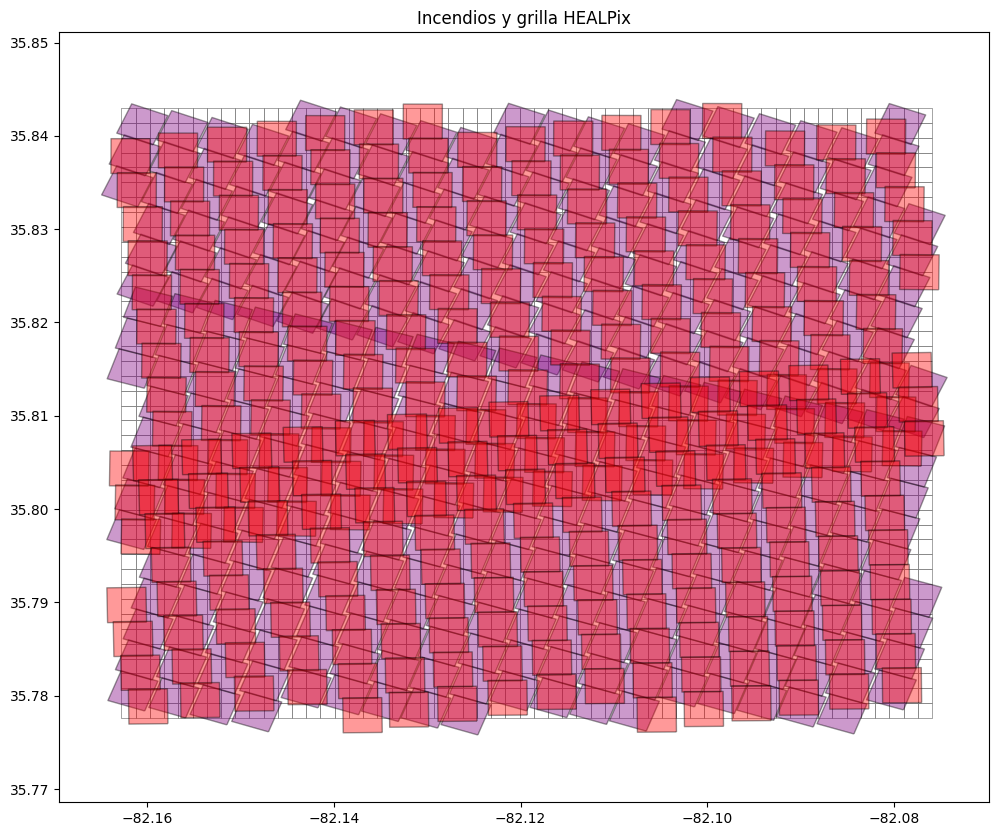

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))

# grilla de fondo
gdf_healpix.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5, label='Grilla HEALPix')

# pixeles de incendio
gdf_pixel_polys1.plot(ax=ax, color= 'purple',edgecolor='black', alpha=0.4, legend=True)
gdf_pixel_polys2.plot(ax=ax, color= 'red',edgecolor='black', alpha=0.4, legend=True)

ax.set_title("Incendios y grilla HEALPix")
plt.axis('equal')
plt.show()

In [21]:
from matplotlib.colors import Normalize

In [22]:
gdf_pixel_polys.date_time.unique()

<DatetimeArray>
['2025-04-12 06:36:00', '2025-04-12 08:18:00', '2025-04-12 18:00:00',
 '2025-04-13 06:18:00', '2025-04-13 08:00:00', '2025-04-13 17:42:00',
 '2025-04-13 19:18:00', '2025-04-14 07:42:00', '2025-04-14 17:18:00',
 '2025-04-14 19:00:00', '2025-04-15 07:24:00', '2025-04-15 18:42:00',
 '2025-04-16 07:06:00', '2025-04-16 18:24:00', '2025-04-17 06:42:00',
 '2025-04-17 08:24:00', '2025-04-17 18:06:00', '2025-04-18 06:24:00',
 '2025-04-18 08:06:00', '2025-04-18 17:48:00', '2025-04-18 19:24:00',
 '2025-04-19 07:48:00', '2025-04-19 17:30:00', '2025-04-19 19:06:00',
 '2025-04-20 07:30:00', '2025-04-20 18:48:00', '2025-04-21 07:12:00',
 '2025-04-21 18:30:00', '2025-04-22 06:48:00', '2025-04-22 18:12:00']
Length: 30, dtype: datetime64[ms]

In [23]:
fechas = ['2025-04-15 07:24:00', '2025-04-15 18:42:00',
          '2025-04-16 07:06:00', '2025-04-16 18:24:00', '2025-04-17 06:42:00',
          '2025-04-17 18:06:00', '2025-04-18 06:24:00',
          '2025-04-18 17:48:00']

In [24]:
gdf_pixel_polys_filt = gdf_pixel_polys[gdf_pixel_polys['date_time'].isin(fechas)]

C:\Users\javie\AppData\Local\Temp\ipykernel_11844\1653676140.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ms] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  gdf_pixel_polys_filt = gdf_pixel_polys[gdf_pixel_polys['date_time'].isin(fechas)]


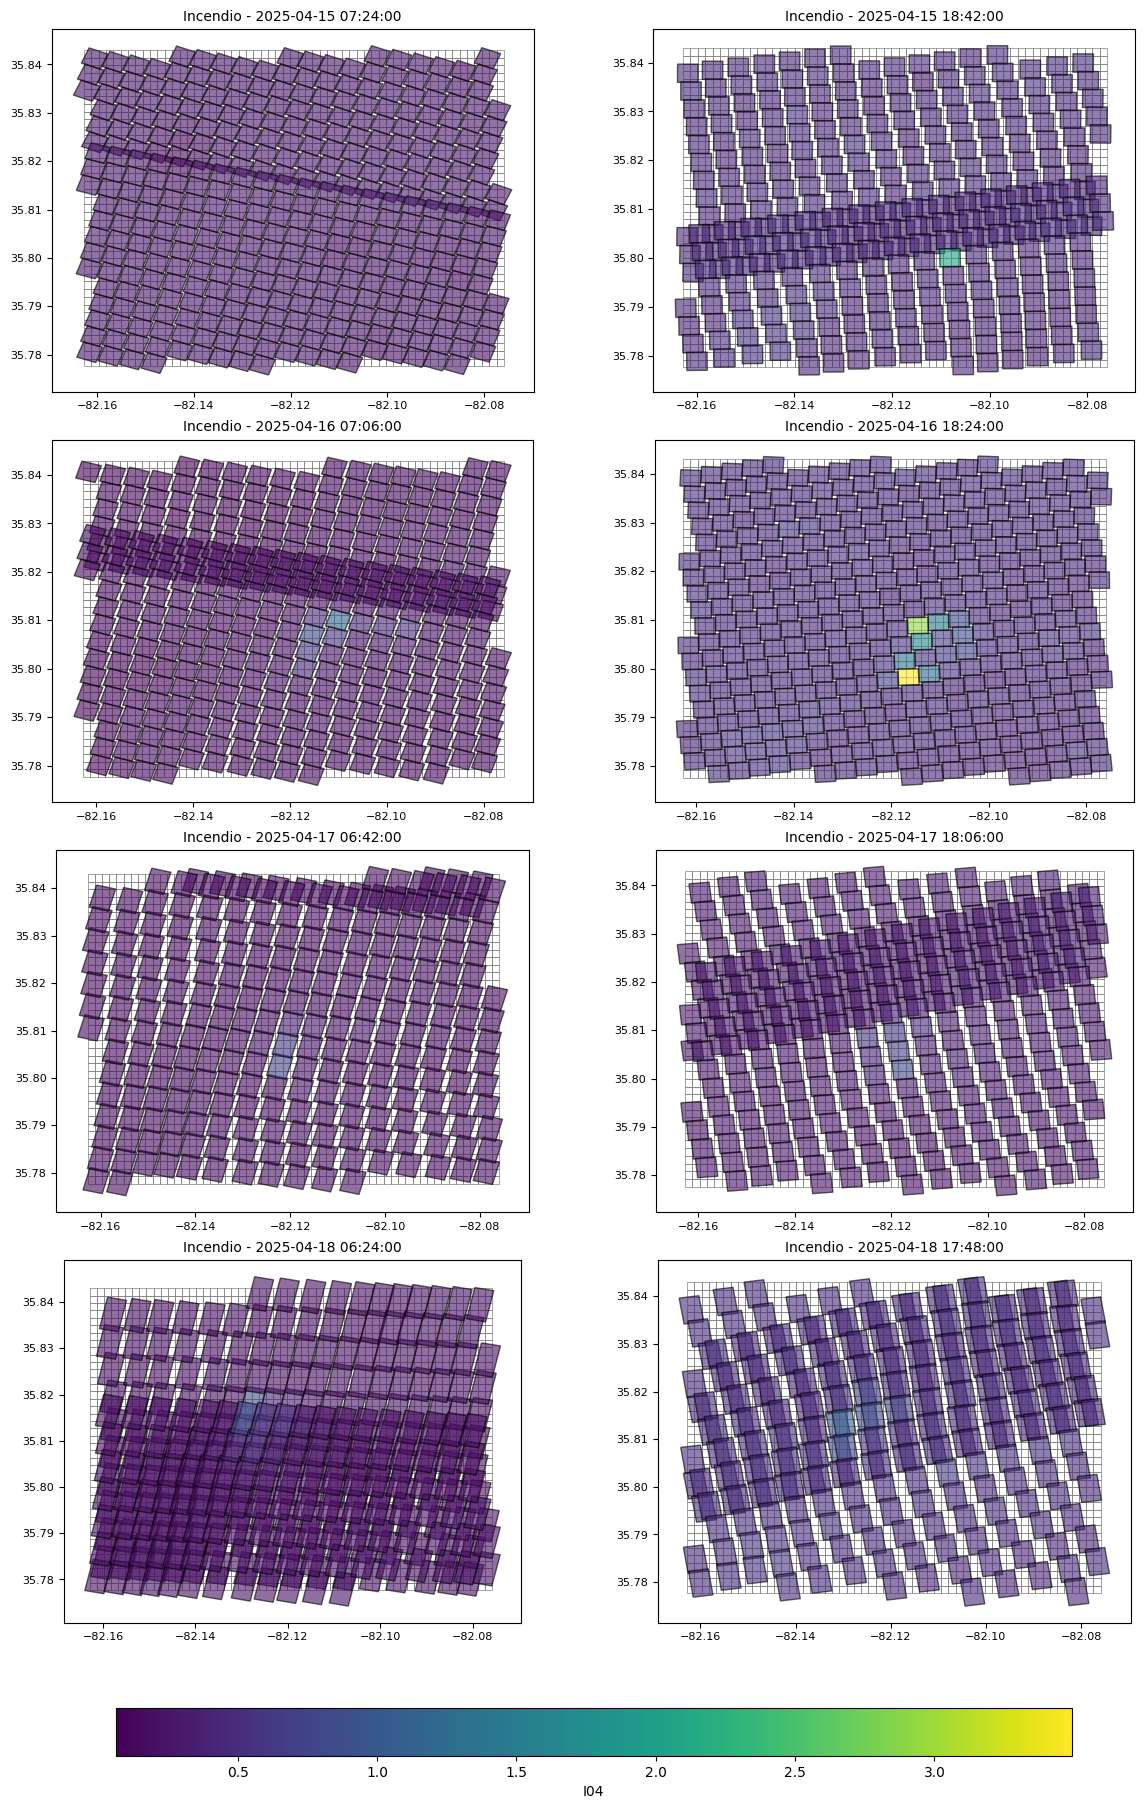

In [ ]:
vmin = gdf_pixel_polys_filt["I04"].min()
vmax = gdf_pixel_polys_filt["I04"].max()
norm = Normalize(vmin=vmin, vmax=vmax)

fig, axes = plt.subplots(4, 2, figsize=(12, 18), constrained_layout=True)
axes = axes.flatten()

# Graficar cada fecha
for i, fecha in enumerate(fechas):
    ax = axes[i]
    gdf_fecha = gdf_pixel_polys[gdf_pixel_polys['date_time'] == fecha]

    gdf_healpix.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5)
    gdf_fecha.plot(ax=ax, column="I04", cmap='viridis', edgecolor='black', alpha=0.6, norm=norm)

    ax.set_title(f"Incendio - {fecha}", fontsize=10)
    ax.set_aspect("equal")

    # Mostrar coordenadas (ticks en grados)
    ax.tick_params(labelsize=8)

# Barra de color compartida
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm._A = []
fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.03, pad=0.04, label="I04")

plt.show()

##### BRILLO (revisar)

In [ ]:
def calc_bt_planck(L, wavelength_um=3.74):
    """
    Calcula la temperatura de brillo
    """
    c1 = 1.19104e8  
    c2 = 1.43877e4  
    
    epsilon = 1e-10  # para evitar division por cero
    term = (c1 / (np.maximum(L, epsilon) * wavelength_um**5)) + 1
    T_b = (c2 / wavelength_um) / np.log(term)
    
    return T_b



In [ ]:
gdf_zonas['BT_I04'] = calc_bt_planck(gdf_zonas['I04'])

In [33]:
aux = gdf_zonas[gdf_zonas.eval('zona == "bee_rock_creek"')]
aux['geometry'] = aux.apply(lambda row: make_viirs_pixel(row['latitude'],
                                                             row['longitude'],
                                                             row['sensor_zenith'],
                                                             row['sensor_azimuth']
                                                             ),
                                axis=1)

gdf_pixel_polys = gpd.GeoDataFrame(aux, geometry='geometry', crs='EPSG:4326')


c:\Users\javie\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [34]:
gdf_pixel_polys_filt = gdf_pixel_polys[gdf_pixel_polys['date_time'].isin(fechas)]

C:\Users\javie\AppData\Local\Temp\ipykernel_11844\1653676140.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ms] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  gdf_pixel_polys_filt = gdf_pixel_polys[gdf_pixel_polys['date_time'].isin(fechas)]


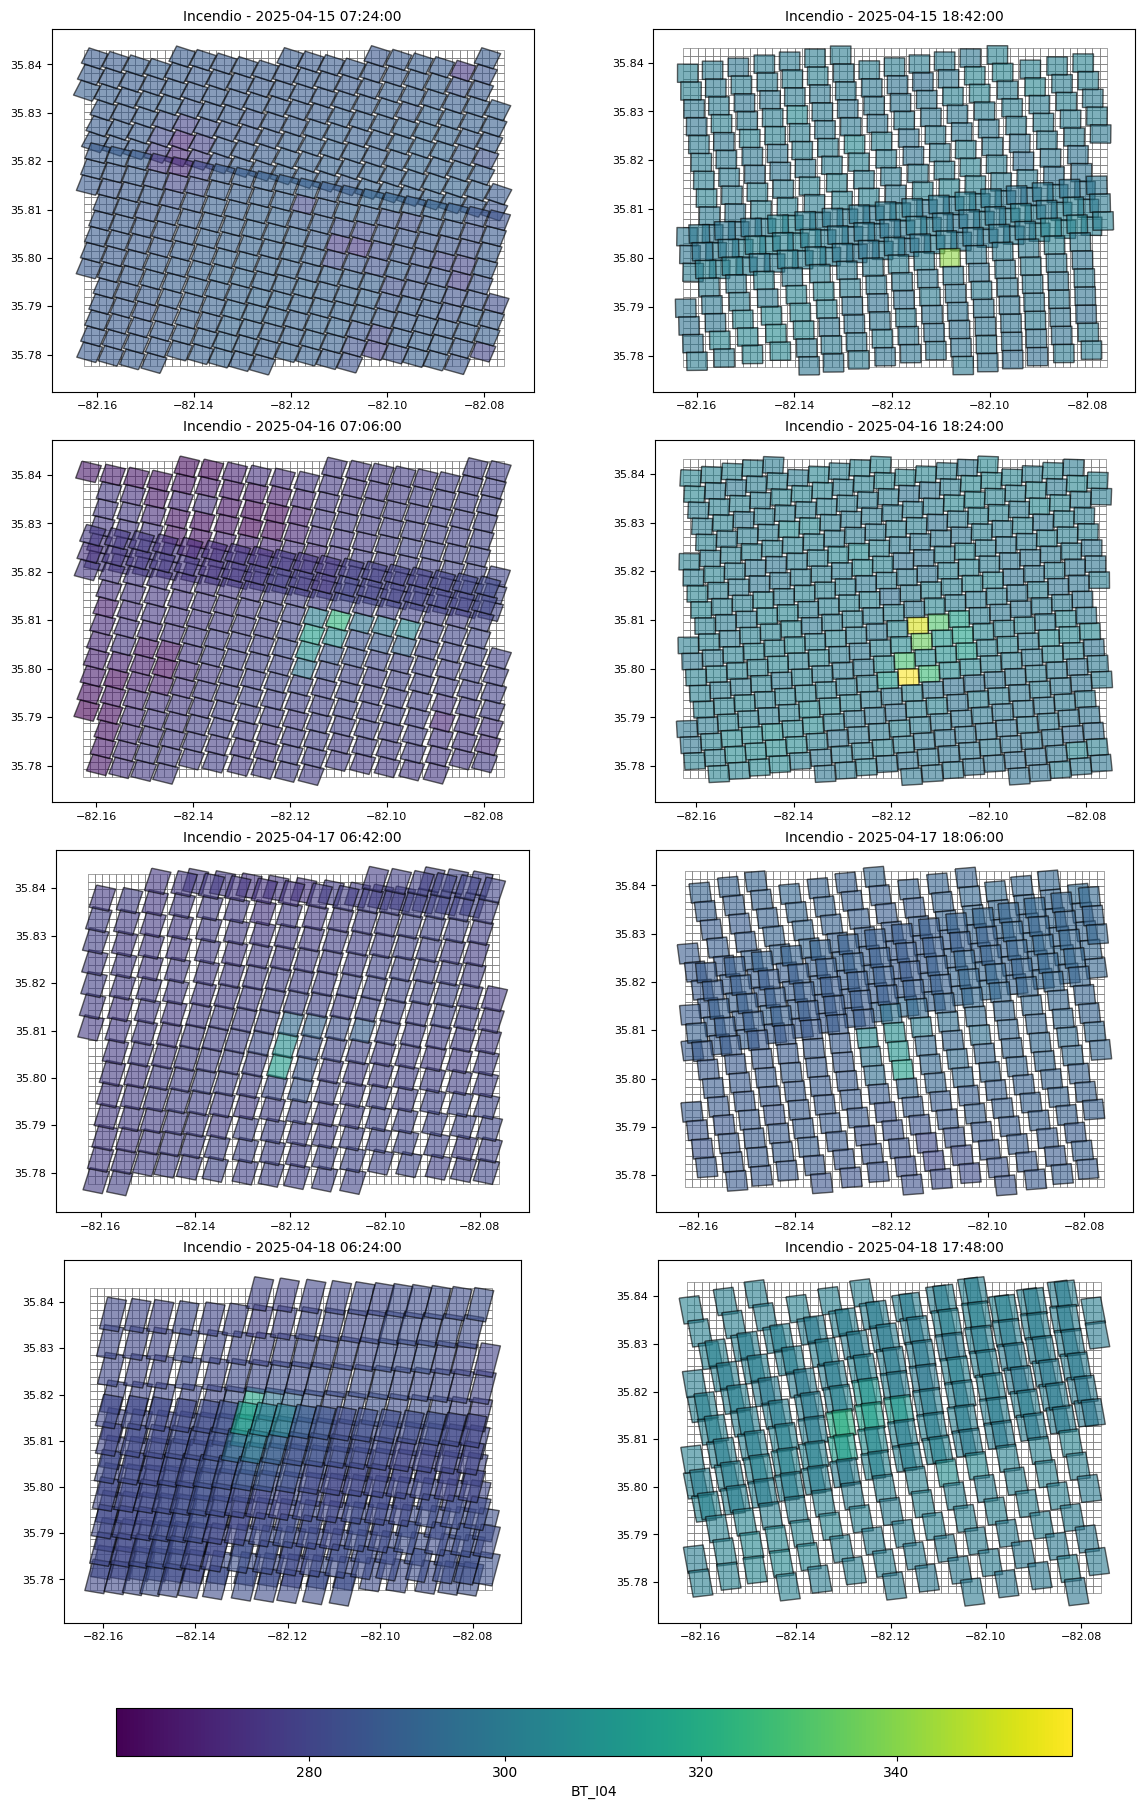

In [35]:
vmin = gdf_pixel_polys_filt["BT_I04"].min()
vmax = gdf_pixel_polys_filt["BT_I04"].max()
norm = Normalize(vmin=vmin, vmax=vmax)

fig, axes = plt.subplots(4, 2, figsize=(12, 18), constrained_layout=True)
axes = axes.flatten()

# Graficar cada fecha
for i, fecha in enumerate(fechas):
    ax = axes[i]
    gdf_fecha = gdf_pixel_polys[gdf_pixel_polys['date_time'] == fecha]

    gdf_healpix.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5)
    gdf_fecha.plot(ax=ax, column="BT_I04", cmap='viridis', edgecolor='black', alpha=0.6, norm=norm)

    ax.set_title(f"Incendio - {fecha}", fontsize=10)
    ax.set_aspect("equal")

    # Mostrar coordenadas (ticks en grados)
    ax.tick_params(labelsize=8)

# Barra de color compartida
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm._A = []
fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.03, pad=0.04, label="BT_I04")

plt.show()